### Import important libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import logging
import warnings
import os
import pickle
from datetime import datetime
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append('../scripts')
from ML_pipline_functions import *

### Load data

In [4]:

# File paths
train_path = 'C:/Users/elbet/OneDrive/Desktop/Ten/Data/rossmann-store-sales/train.csv'
test_path = 'C:/Users/elbet/OneDrive/Desktop/Ten/Data/rossmann-store-sales/test.csv'
store_path = 'C:/Users/elbet/OneDrive/Desktop/Ten/Data/rossmann-store-sales/store.csv'


# Load and clean data
train, test = load_data(train_path, test_path, store_path)
train_cleaned, test_cleaned = clean_data(train, test)

In [5]:
print("Train columns:", train_cleaned.columns)
print("Test columns:", test_cleaned.columns)

Train columns: Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day'],
      dtype='object')
Test columns: Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Year', 'Month',
       'Day'],
      dtype='object')


### Preprocessing data

In [6]:
# Prepare training and validation datasets
train_df = train_cleaned[train_cleaned.Date.dt.year <= 2014]
val_df = train_cleaned[train_cleaned.Date.dt.year == 2015]

input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'StoreType', 'Assortment', 'Promo2', 'Day', 'Month', 'Year']
target_col = 'Sales'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()
test_inputs = test_cleaned[input_cols].copy()

num_cols = ['Store', 'DayOfWeek', 'Day', 'Month', 'Year']
cat_cols = ['DayOfWeek', 'Promo', 'StoreType', 'Assortment', 'Promo2']

train_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
236380      1          3 2014-12-31   2605        327     1      0   
236381      2          3 2014-12-31   2269        252     1      0   
236382      3          3 2014-12-31   3804        408     1      0   
236383      4          3 2014-12-31  10152       1311     1      0   
236384      5          3 2014-12-31   1830        217     1      0   

       StateHoliday  SchoolHoliday StoreType  ... CompetitionDistance  \
236380            0              1         c  ...              1270.0   
236381            0              1         a  ...               570.0   
236382            0              1         a  ...             14130.0   
236383            0              1         c  ...               620.0   
236384            0              1         a  ...             29910.0   

        CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
236380                        9.0                    2008.0       0   
236381                       11.0                    2007.0       1   
236382                       12.0                    2006.0       1   
236383                        9.0                    2009.0       0   
236384                        4.0                    2015.0       0   

        Promo2SinceWeek  Promo2SinceYear    PromoInterval  Year  Month  Day  
236380              NaN              NaN              NaN  2014     12   31  
236381             13.0           2010.0  Jan,Apr,Jul,Oct  2014     12   31  
236382             14.0           2011.0  Jan,Apr,Jul,Oct  2014     12   31  
236383              NaN              NaN              NaN  2014     12   31  
236384              NaN              NaN              NaN  2014     12   31  

[5 rows x 21 columns]

In [7]:
val_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType  ... CompetitionDistance  \
0              1         c  ...              1270.0   
1              1         a  ...               570.0   
2              1         a  ...             14130.0   
3              1         c  ...               620.0   
4              1         a  ...             29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  Year  Month  Day  
0              NaN              NaN              NaN  2015      7   31  
1             13.0           2010.0  Jan,Apr,Jul,Oct  2015      7   31  
2             14.0           2011.0  Jan,Apr,Jul,Oct  2015      7   31  
3              NaN              NaN              NaN  2015      7   31  
4              NaN              NaN              NaN  2015      7   31  

[5 rows x 21 columns]

### Building models with sklearn pipelines

In [8]:
# Create pipeline
pipeline = create_pipeline(input_cols, num_cols, cat_cols)

### FIT, Evaluate and Serialize Model

In [9]:
# Fit and evaluate models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1)
}

# Path to save the models
saved_dir = "C:/Users/elbet/OneDrive/Desktop/Ten/Predictive_Pharmaceutical_data_analysis_Saved_models"
os.makedirs(saved_dir, exist_ok=True)  

for name, model in models.items():
    print(f"Evaluating model: {name}")
    
    # Transform inputs using the pipeline
    train_inputs_transformed = pipeline.fit_transform(train_inputs)
    val_inputs_transformed = pipeline.transform(val_inputs)
    
    # Assuming try_model is a function that fits and evaluates the model
    # Here I have used rsme loss function as defined in ML_pipline_functions
    try_model(model, train_inputs_transformed, train_targets, val_inputs_transformed, val_targets)

    # Serialize the model
    timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
    model_filename = f"{name.replace(' ', '_')}_{timestamp}.pkl"
    model_filepath = os.path.join(saved_dir, model_filename)  # Save to the correct directory
    
    with open(model_filepath, 'wb') as file:  # Use full file path
        pickle.dump(model, file)
        
    print(f"Model saved as: {model_filepath}")


Evaluating model: Linear Regression
Train RMSE: 2757.2735750896727
Val RMSE: 2669.332516166317
Train RMSPE: 0.5454149922006996
Val RMSPE: 0.4863475286142723
Model saved as: C:/Users/elbet/OneDrive/Desktop/Ten/Predictive_Pharmaceutical_data_analysis_Saved_models\Linear_Regression_24-09-2024-11-29-37.pkl
Evaluating model: Decision Tree
Train RMSE: 0.0
Val RMSE: 1395.424142469505
Train RMSPE: 0.0
Val RMSPE: 0.21623589672660085
Model saved as: C:/Users/elbet/OneDrive/Desktop/Ten/Predictive_Pharmaceutical_data_analysis_Saved_models\Decision_Tree_24-09-2024-11-29-41.pkl
Evaluating model: Random Forest
Train RMSE: 406.97591681710804
Val RMSE: 1142.9126381766223
Train RMSPE: 0.094910802302245
Val RMSPE: 0.17983194076703538
Model saved as: C:/Users/elbet/OneDrive/Desktop/Ten/Predictive_Pharmaceutical_data_analysis_Saved_models\Random_Forest_24-09-2024-11-30-11.pkl


In [11]:
# Predict on test set
test_inputs_transformed = pipeline.transform(test_inputs)
test_preds = models["Random Forest"].predict(test_inputs_transformed)

# Add Store identifier from the test dataset
test_preds_df_with_store = pd.DataFrame({
    'Store': test_inputs['Store'],  
    'Predicted Sales': test_preds
})

# Print the first few rows with store information and predictions
print(test_preds_df_with_store.head())

   Store  Predicted Sales
0      1          4289.03
1      3          7740.33
2      7          8757.85
3      8          6878.76
4      9          6566.67


### Post Prediction Analysis

In [12]:
# Get feature names from the pipeline's transformer
onehot_columns = list(pipeline.named_steps['preprocessor'].transformers_[1][1]\
                      .named_steps['onehot'].get_feature_names_out(cat_cols))
num_columns = num_cols # numeric feature columns

# Print the one-hot encoded feature names and numeric feature names
print("One-Hot Encoded Feature Names:")
print(onehot_columns)
print("\nNumerical Feature Names:")
print(num_columns)


One-Hot Encoded Feature Names:
['DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'Promo_0', 'Promo_1', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'Promo2_0', 'Promo2_1']

Numerical Feature Names:
['Store', 'DayOfWeek', 'Day', 'Month', 'Year']


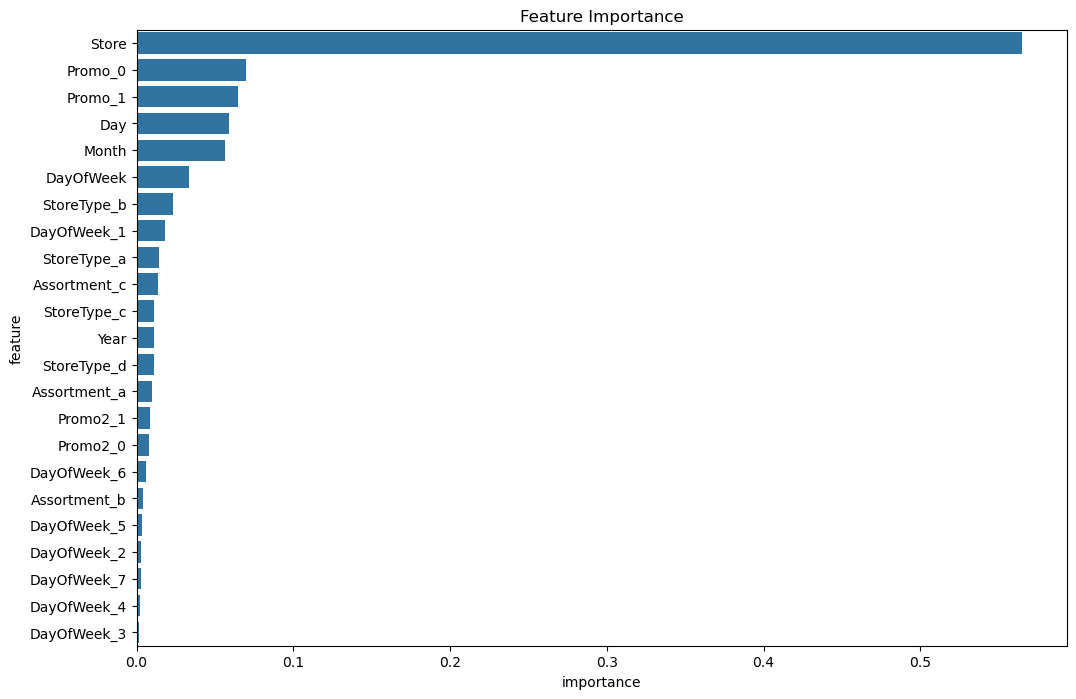

In [13]:
# Combine the columns from numeric and one-hot encoded features
all_columns = num_columns + onehot_columns
# Feature importance
feature_importance_df = pd.DataFrame({
    'feature': all_columns,  # Use the updated feature names
    'importance': models["Random Forest"].feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, x='importance', y='feature')
plt.title('Feature Importance')
plt.show()
